In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

ModuleNotFoundError: No module named 'pandas'

In [ ]:
df = pd.read_csv("save_data_test.csv", nrows=600, skiprows=150)

L = df.columns.to_list()
time_cols = L[0::4]
sb_cols = L[1::4]
pb_cols = L[2::4]
wb_cols = L[3::4]
df[pb_cols] = df[pb_cols].to_numpy() / 1e5

fig, axs = plt.subplots(3, 1, figsize=(8, 6))
df[sb_cols].plot(ax=axs[0])
df[pb_cols].plot(ax=axs[1])
df[wb_cols].plot(ax=axs[2])
axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[2].get_legend().remove()

In [ ]:
df = pd.read_csv("save_data_validate.csv", nrows=600, skiprows=150)
L = df.columns.to_list()
time_cols = L[0::4]
sb_cols = L[1::4]
pb_cols = L[2::4]
wb_cols = L[3::4]
df[pb_cols] = df[pb_cols].to_numpy() / 1e5

fig, axs = plt.subplots(4, 1, figsize=(8, 6))
df[sb_cols].plot(ax=axs[0])
df[pb_cols].plot(ax=axs[1])
df[wb_cols].plot(ax=axs[2])
df[time_cols].plot(ax=axs[3])
axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[2].get_legend().remove()


In [ ]:
df = pd.read_csv("save_data_test.csv", nrows=600, header=0, skiprows=[x for x in range(1,100)])


In [ ]:

k=np.random.randint(0,500,1)[0]

fig, axs = plt.subplots(3, 1, figsize=(8, 6))
df[f"sb_{k}"].plot(ax=axs[0], label="sb", color="red")
df[f"pb_{k}"]=df[f"pb_{k}"]/1e5
df[f"pb_{k}"].plot(ax=axs[1], label="p_b", color="green")
df[f"wb_{k}"].plot(ax=axs[2], label="w_b")
for i in range(3):
    axs[i].legend()
    axs[i].grid()


In [ ]:
import torch
import matplotlib.pyplot as plt

In [ ]:
tensor = torch.tensor(df.values)
tensor = tensor.view(600,500,4).permute(1,0,2)

In [ ]:
tensor.size()


In [ ]:

def get_data(path = "ventil_lstm\save_data_test.csv"):
    
    df = pd.read_csv(path, header=0, nrows=600, skiprows=[x for x in range(1,100)])

    #Reorder columns for familiar setup (t,u,x) here (t, p_b, s_b, w_b)
    L = df.columns.to_list()
    time_cols = L[0::4]
    sb_cols = L[1::4]
    pb_cols = L[2::4]
    wb_cols = L[3::4]
    new_col_order = [x for sub in list(zip(time_cols, pb_cols, sb_cols, wb_cols)) for x in sub]
    df= df[new_col_order]
    df = df.drop(time_cols, axis=1)

    #normalise each column of the dataframe
    #mean normalization
    #df=(df-df.mean())/df.std()

    #min max normalization
    #normalize only a part of the data(??)
    df[sb_cols+wb_cols]=(df[sb_cols+wb_cols]-df[sb_cols+wb_cols].min())/(df[sb_cols+wb_cols].max()-df[sb_cols+wb_cols].min())
    #Can't normalize p_b because then a[i]*X+b[i] becomes cX+d for all i.. same with mean normal. 
    df[pb_cols] = df[pb_cols] / 1e5

    tensor = torch.tensor(df.values)

    #tensor with t=0:600, 500 different input and the 4 outputs [time, s_b, p_b, w_b]
    tensor = tensor.view(600,500,3).permute(1,0,2)


    return tensor


In [ ]:
df = pd.read_csv("save_data_test.csv", header=0, nrows=600, skiprows=[x for x in range(1,100)])

#Reorder columns for familiar setup (t,u,x) here (t, p_b, s_b, w_b)
L = df.columns.to_list()
time_cols = L[0::4]
sb_cols = L[1::4]
pb_cols = L[2::4]
wb_cols = L[3::4]
new_col_order = [x for sub in list(zip(time_cols, pb_cols, sb_cols, wb_cols)) for x in sub]
df= df[new_col_order]
df = df.drop(time_cols, axis=1)

#normalise each column of the dataframe
#mean normalization
#df=(df-df.mean())/df.std()

#min max normalization
df[sb_cols+wb_cols]=(df[sb_cols+wb_cols]-df[sb_cols+wb_cols].min())/(df[sb_cols+wb_cols].max()-df[sb_cols+wb_cols].min())

df[pb_cols] = df[pb_cols] / 1e5


In [10]:

a = torch.tensor([1,2,3])

for i, x in enumerate(a): print(i, x)

0 tensor(1)
1 tensor(2)
2 tensor(3)


torch.Size([90, 600, 3])


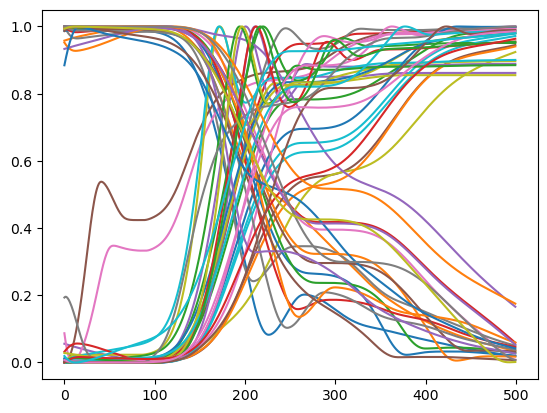

In [95]:
input_data = get_data(path="save_data_test.csv")

train_size = int(0.9 * len(input_data))
test_size = len(input_data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(input_data, [train_size, test_size])

print(tensor.size())
tensor=tensor[1:100, :, :]
for x in test_dataset:
    plt.plot(x[:500,1])
plt.show()

In [144]:
# torch.version.cuda(): Returns CUDA version of the currently installed packages
# torch.cuda.is_available(): Returns True if CUDA is supported by your system, else False
# torch.cuda.current_device(): Returns ID of current device
# torch.cuda.get_device_name(device_ID): Returns name of the CUDA device with ID = ‘device_ID’
print( torch.cuda.is_available())


False


In [145]:

def test(test_data, model, steps=600, ws=10):

    model.eval()
    loss_fn = nn.MSELoss()
    test_loss = 0
    test_loss_deriv = 0

    for i, x in enumerate(test_data):
        
        if i > 3:
            break

        with torch.inference_mode():

            pred = torch.zeros((steps, 3))
            pred_next_step = torch.zeros((steps, 3))

            if ws > 1:
                pred[0:ws, :] = x[0:ws, :]
                pred[:, 0] = x[:, 0]
                pred_next_step[0:ws, :] = x[0:ws, :]
                pred_next_step[:, 0] = x[:, 0]
            else:
                pred[0, :] = x[0, :]
                pred[:, 0] = x[:, 0]
                pred_next_step[0, :] = x[0, :]
                pred_next_step[:, 0] = x[:, 0]

            for i in range(len(x) - ws):
                out, _ = model(pred[i:i+ws, :])

                pred[i+ws, 1:] = pred[i+ws-1, 1:] + out[-1, :]
                pred_next_step[i+ws, 1:] = x[i+ws-1, 1:] + out[-1, :]


            test_loss += loss_fn(pred[:, 1], x[:, 1]).detach().numpy()
            test_loss_deriv += loss_fn(pred[:, 2], x[:, 2]).detach().numpy()
            figure , axs = plt.subplots(3,1)
            
            axs[0].plot(np.linspace(0,1,steps), pred.detach().numpy()[:, 1], color="red", label="pred")
            axs[0].plot(np.linspace(0,1,steps), pred_next_step.detach().numpy()[:, 1], color="green", label="next step from data")
            axs[0].plot(np.linspace(0,1,steps), x.detach().numpy()[:, 1], color="blue", label="true", linestyle="dashed")

            axs[0].grid()
            axs[0].legend()

            axs[1].plot(np.linspace(0,1,steps), pred.detach().numpy()[
            :, 2], color="red", label="pred")
            axs[1].plot(np.linspace(0,1,steps), pred_next_step.detach().numpy()[:, 2], color="green", label="next step from data")
            axs[1].plot(np.linspace(0,1,steps), x.detach().numpy()[:, 2], color="blue", label="true", linestyle="dashed")

            axs[1].grid()
            axs[1].legend()
            axs[2].plot(np.linspace(0,1,steps), x.detach().numpy()[:,0], label="pressure")

            axs[2].grid()
            axs[2].legend()
            

    return np.mean(test_loss), np.mean(test_loss_deriv)


(37.59180428205008, 628.0963585363214)

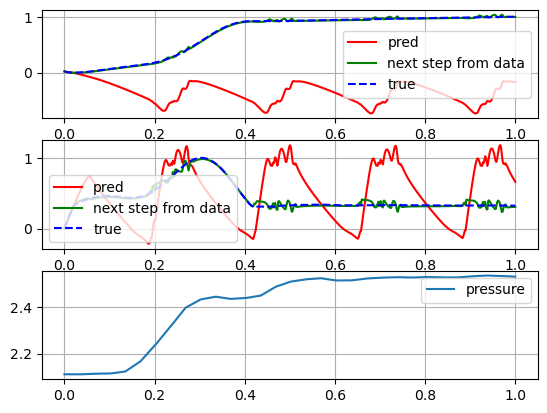

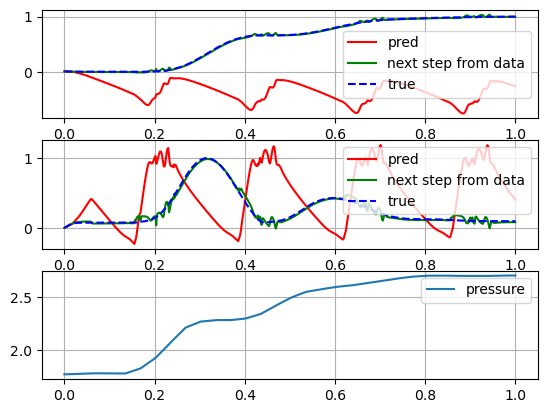

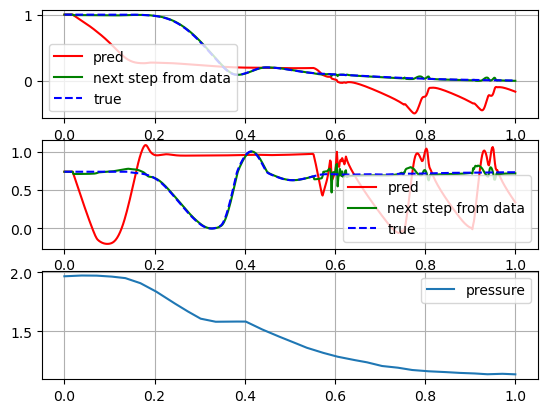

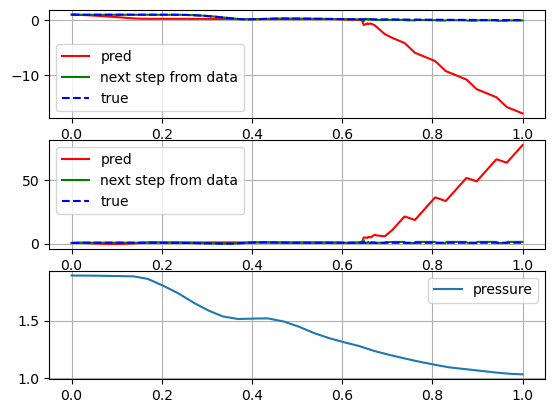

In [160]:
input_data = get_data(path="save_data_test.csv")

# Split data into train and test sets
train_size = int(0.7 * len(input_data))
test_size = len(input_data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(input_data, [train_size, test_size])

# Take a slice of data for training (only slice_of_data many timesteps)
slice_of_data = 60

train_dataset = train_dataset[:][:, 0:slice_of_data, :]

model = LSTMmodel(input_size=3, hidden_size=5, out_size=2, layers=1).to("cpu")


path = f"Ventil_trained_NNs\lstm_ws{16}.pth"

model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
test(test_dataset, model, steps=600, ws=12)